In [ ]:
!pip install pydub pyannote.audio

In [4]:
from huggingface_hub import notebook_login
notebook_login()

Token has not been saved to git credential helper.


In [10]:
import torch

In [2]:
from pyannote.audio import Pipeline

In [6]:
diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [11]:
diarization_pipeline.to(torch.device("cuda"))

In [7]:
from pyannote.audio.pipelines.utils.hook import ProgressHook

In [ ]:
with ProgressHook() as hook:
  diarization = diarization_pipeline("/content/interview.mp3", hook=hook)

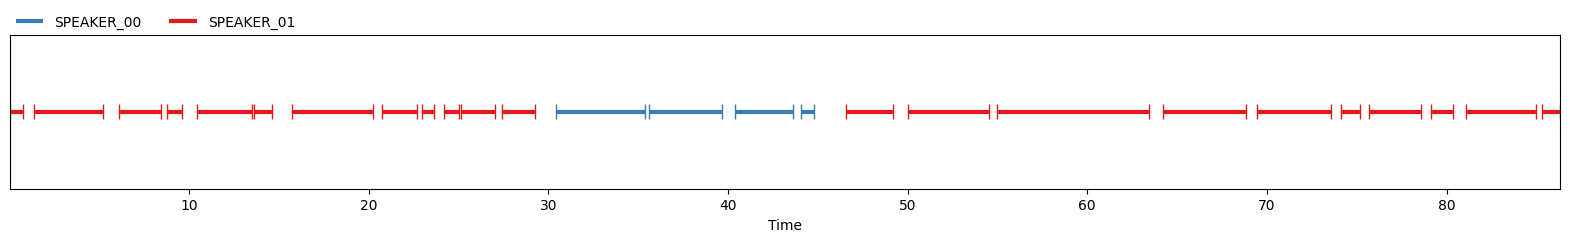

In [13]:
diarization

In [14]:
diarization.chart()

[('SPEAKER_01', 57.7125), ('SPEAKER_00', 12.976875000000003)]

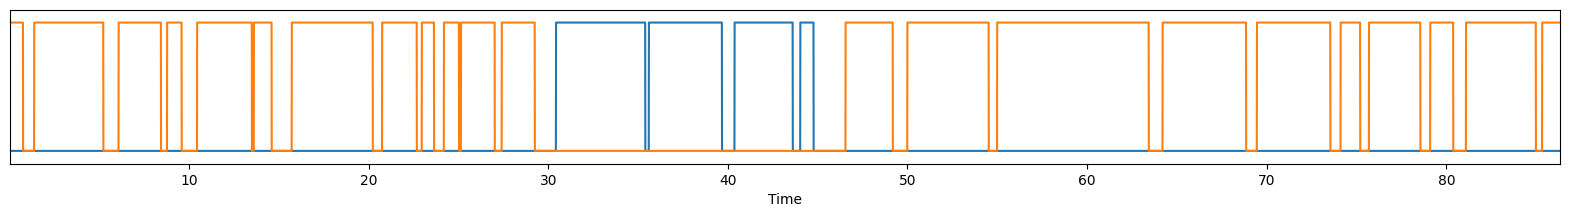

In [15]:
diarization.discretize()

In [ ]:
# print the result
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

In [17]:
def consolidate_speaker_segments(diarization):
    consolidated_segments = []
    current_speaker = None
    segment_start = None

    for turn, _, speaker in diarization.itertracks(yield_label=True):
        if speaker != current_speaker:
            if current_speaker is not None:
                consolidated_segments.append((current_speaker, segment_start, turn.start))
            current_speaker = speaker
            segment_start = turn.start
        segment_end = turn.end

    if current_speaker is not None:
        consolidated_segments.append((current_speaker, segment_start, segment_end))

    return consolidated_segments

In [18]:
# Example usage with the provided diarization object:
segments = consolidate_speaker_segments(diarization)

In [19]:
segments

[('SPEAKER_01', 0.03096875, 30.43971875),
 ('SPEAKER_00', 30.43971875, 46.555343750000006),
 ('SPEAKER_01', 46.555343750000006, 86.31284375)]

In [20]:
for speaker, start, end in segments:
    print(f"speaker_{speaker} start={start:.1f}s stop={end:.1f}s")

speaker_SPEAKER_01 start=0.0s stop=30.4s
speaker_SPEAKER_00 start=30.4s stop=46.6s
speaker_SPEAKER_01 start=46.6s stop=86.3s


In [21]:
from pydub import AudioSegment
import os

def split_audio_segments(audio_file, segments, output_dir='segmented_audio'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load the audio file
    audio = AudioSegment.from_file(audio_file)

    # Iterate over the segments and export each one
    for idx, (speaker, start, end) in enumerate(segments):
        # Calculate start and end in milliseconds
        start_ms = start * 1000
        end_ms = end * 1000

        # Extract the segment
        segment = audio[start_ms:end_ms]

        # Create the output file name
        speaker_label = speaker.split('_')[-1]  # Get speaker identifier
        output_file = os.path.join(output_dir, f"{idx:02d}_SPEAKER{speaker_label}_START{start:.0f}_STOP{end:.0f}.mp3")

        # Export the segment
        segment.export(output_file, format="mp3")
        print(f"Exported {output_file}")

In [22]:
split_audio_segments('interview.mp3',segments)

Exported segmented_audio/00_SPEAKER01_START0_STOP30.mp3
Exported segmented_audio/01_SPEAKER00_START30_STOP47.mp3
Exported segmented_audio/02_SPEAKER01_START47_STOP86.mp3


In [25]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# model = https://huggingface.co/facebook/wav2vec2-base-960h
pipe = pipeline("automatic-speech-recognition", device=0)

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 22aad52 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [26]:
import os
import re

def process_segmented_files(directory='segmented_audio'):
    # Ensure the directory exists
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory '{directory}' does not exist.")

    # List all files in the directory
    files = os.listdir(directory)


    # Process each file
    for file in files:
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            text = pipe(file_path)['text']
            num,speaker,time_start,time_stop = file.split('_')
            time_stop = time_stop.replace(".mp3",'')
            print(f"{speaker}-- {time_start}sec {time_stop}sec:\n{text}")
            print('\n\n')

In [27]:
process_segmented_files()

SPEAKER01-- START0sec STOP30sec:
MOST OF US WOULD BE SURPRISED TO HEAR THAT THE UNIVERSE IS GOING TO END ONE DAY WE EXPECT THE UNIVERSE TO GO ON FOREVER INTO THE FUTURE WHY DO WE HAVE THE IDEA THAT IT DOESN'T GO ON FOREVER INTO THE PAST I'M NOT SAYING I KNOW THE ANSWER TO THIS THIS IS ONE OF THE DEEPEST QUESTIONS AND WE DO NOT KNOW THE ANSWER WE SIMPLY HAVE TO KEEP AN OPEN MIND ALL OF US PHILOSOPHERS SCIENCES RELIGIOUS PEOPLE NO ONE IN FACT KNOWS



SPEAKER01-- START47sec STOP86sec:
WELL FIRST OFF AS YOU SUGGEST WE A WE ARE A WANDERING SPECIES WE COME FROM HUNTER GATHERERS WE ORE GNOMADS AND FOR THE MILLION YEARS THAT THE HUMAN FAMILY HAS BEEN AROUND THAT WAS OUR LIFE STYLE THAT MUST BE BUILT INTO US DEEPLY IT'S ONLY THE LAST TEN THOUSAND YEARS THAT WE'VE HAD A SETTLED AND SEDENTARY EXISTENCE AND NOW THE EARTH IS ALL EXPLORED OUR EXPLORATORY INSTINCTS ARE UNFULFILLED AND I THINK MANY PEOPLE I RECOGNIZE NOT ALL BUT MANY PEOPLE WOULD LONG FOR REAL EXPLORATION OF REAL NEW WORLD EVEN VICAR